In [14]:
import numpy as np
from solver_selector.performance_predictor import PerformancePredictorEpsGreedy
from data_scripts import load_data
from thermal_solvers import make_thermal_solver_space
from matplotlib import pyplot as plt

N_NEWEST = 5

def only_cpr(path):
    data = load_data(path, n_newest=N_NEWEST)
    results = []
    for sim in data:
        results.extend([val for val in sim if 'cpr' in val.config['gmres']['preconditioner']])
    return results

data_l = only_cpr('/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/thermal_coldstart_l.py')
data_m = only_cpr('/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/thermal_coldstart_m.py')
data_s = only_cpr('/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/thermal_dynamic.py')

np.random.seed(42)
np.random.shuffle(data_l)

Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_4.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_5.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_6.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_7.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_l_8.npy
Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_9.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_10.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_11.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/2/performance/thermal_coldstart_m_12.n

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from typing import Sequence
import numpy as np


class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        base_regressors: Sequence[BaseEstimator],
        online_regressor: BaseEstimator,
    ):
        self.base_regressors: Sequence[BaseEstimator] = base_regressors
        self.online_regressor: BaseEstimator = online_regressor
        self.trust_model = Ridge()

    def _predict_regressors(self, X):
        predictions = []
        for reg in self.base_regressors:
            predictions.append(reg.predict(X))
        predictions.append(self.online_regressor.predict(X))
        return np.array(predictions).T

    def fit(self, X, y):
        self.online_regressor.fit(X, y)
        predictions = self._predict_regressors(X)
        self.trust_model.fit(predictions, y)

        return self

    def predict(self, X):
        predictions = self._predict_regressors(X)
        return self.trust_model.predict(predictions)

In [16]:
cpr = make_thermal_solver_space(solver='cpr').get_all_solvers()[0]
predictor_s = PerformancePredictorEpsGreedy(decision_template=cpr)
predictor_s.offline_update(data_s)

predictor_m = PerformancePredictorEpsGreedy(decision_template=cpr)
predictor_m.offline_update(data_m)

mat_size_s = np.log(data_s[0].prediction.context.mat_size)
mat_size_m = np.log(data_m[0].prediction.context.mat_size)
mat_size_l = np.log(data_l[0].prediction.context.mat_size)

mat_size_s, mat_size_m, mat_size_l

(9.574983485564092, 10.181119289134408, 11.790557201568507)

In [23]:
def compare(div):
    data_l_train, data_l_test = data_l[:div], data_l[div:]

    scaling_predictor = CustomRegressor(
        base_regressors=[predictor_s.regressor, predictor_m.regressor],
        online_regressor=PerformancePredictorEpsGreedy(decision_template=cpr).regressor,
    )

    predictor_l = PerformancePredictorEpsGreedy(decision_template=cpr, samples_before_fit=0)
    predictor_l.offline_update(data_s)
    predictor_l.offline_update(data_m)
    predictor_l.offline_update(data_l_train)

    predictor_l_test = PerformancePredictorEpsGreedy(decision_template=cpr, regressor=scaling_predictor, samples_before_fit=0)
    predictor_l_test.offline_update(data_l_train)

    full_contexts_list = []
    rewards_list = []
    for selection_data in data_l_test:
        full_context, rewards = predictor_l_test._prepare_fit_data(selection_data)
        full_contexts_list.append(full_context)
        rewards_list.append(rewards)
    full_contexts = np.concatenate(full_contexts_list)
    rewards = np.concatenate(rewards_list)
    baseline = predictor_l.regressor.score(full_contexts, rewards)
    new = predictor_l_test.regressor.score(full_contexts, rewards)
    coefs = list(predictor_l_test.regressor.trust_model.coef_) + [predictor_l_test.regressor.trust_model.intercept_]
    return baseline, new, coefs

In [25]:
from tqdm import tqdm

b_list = []
n_list = []
c_list = []
for i in tqdm(range(1, 50)):
    baseline, new, coefs = compare(div=i)
    b_list.append(baseline)
    n_list.append(new)
    c_list.append(coefs)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


accuracy $\in (-\inf, 1)$
* accuracy == 0 - constant model that always returns the average value
* accuracy == 1 - perfect

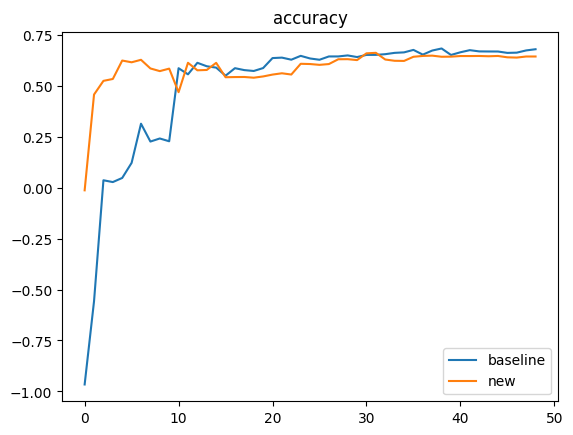

In [26]:
plt.plot(b_list, label='baseline')
plt.plot(n_list, label='new')
plt.title('accuracy')
# plt.ylim(0, 1)
plt.legend()

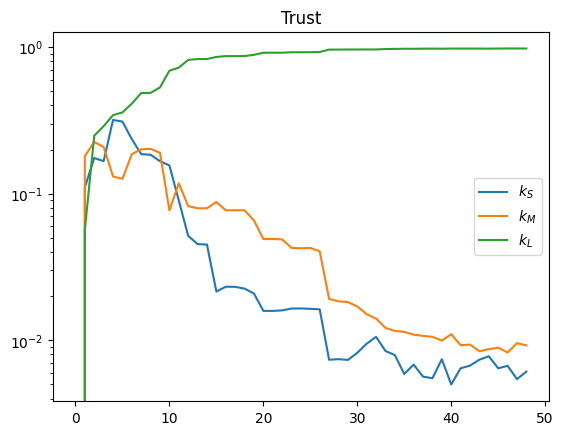

In [27]:
plt.plot(np.array(c_list)[:, 0], label='$k_S$')
plt.plot(np.array(c_list)[:, 1], label='$k_M$')
plt.plot(np.array(c_list)[:, 2], label='$k_L$')
# plt.plot(np.array(c_list)[:, 3], label='$b$')
plt.title('Trust')
plt.yscale('log')
plt.legend()